# Analyzing wave measurements from UDM

## Experiment parameters

* Date: 2019-11-21
* Tank: SUSTAIN
* Start time: 16:10 UTC
* Wind only, no paddle
* Fan from 0 to 60 Hz in 5 Hz intervals, each run 600 s (10 minutes)
* Fresh water
* Mean water depth: 0.8 m

## Loading the data

In [1]:
from asist.utility import binavg, running_mean, power_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend
from sustain_drag_2020.udm import read_udm_from_toa5
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data parameters
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191121'
files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_ELEVx6_20Hz*.dat')

# experiment parameters
start_time = datetime(2019, 11, 21, 16, 10)
fan = range(0, 65, 5)
run_seconds = 600

In [3]:
# read UDM data from TOA5 files
time, u1, u2, u3, u4, u5, u6 = read_udm_from_toa5(files)

Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1275_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1276_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1277_2019_11_21_1800.dat


In [4]:
def elevation_from_udm(x):
    """Remove spikes and offset."""
    xx = x[:]
    for n in range(5):
        for i in range(1, xx.size-1):
            if xx[i] > 1.6:
                xx[i] = 0.5 * (xx[i-1] + xx[i+1])
    offset = np.mean(xx[:1200])
    xx = offset - xx
    return xx

Text(0, 0.5, 'Elevation [m]')

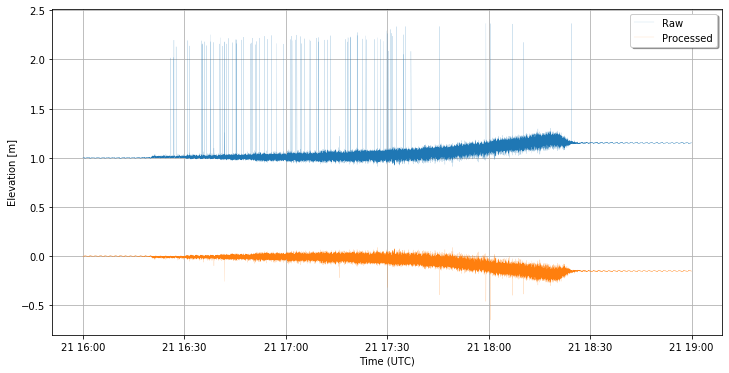

In [5]:
fig = plt.figure(figsize=(12, 6))
plt.plot(time, u3, lw=0.1, label='Raw')
plt.plot(time, elevation_from_udm(u3), lw=0.1, label='Processed')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.grid()
plt.xlabel('Time (UTC)')
plt.ylabel('Elevation [m]')

In [6]:
# map UDM arrays to sequential positions in the tank
udm = np.zeros((5, u1.size))
udm[0,:] = u6[:]
udm[1,:] = u5[:]
udm[2,:] = u1[:]
udm[3,:] = u3[:]
udm[4,:] = u4[:]

fetch = np.array([3, 6, 9, 12, 15]) # TODO get exact values

## Computing wave spectra

In [7]:
# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0 = [start_time + timedelta(seconds=n * run_seconds + 60)
    for n in range(len(fan))]
t1 = [start_time + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


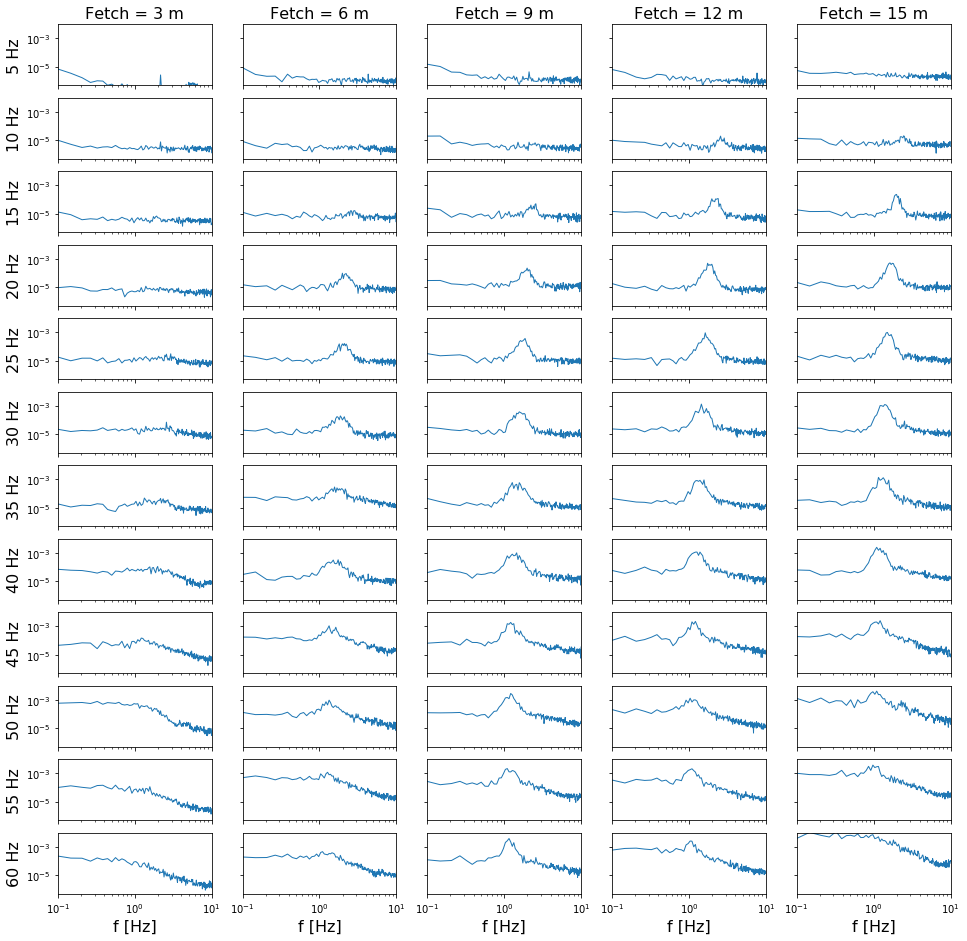

In [8]:
fig = plt.figure(figsize=(16, 16))
for n in range(1, len(fan)):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    mask = (time >= t0[n]) & (time <= t1[n])
    for i in range(5):
        ax = plt.subplot2grid((12, 5), (n - 1, i))
        e = detrend(elevation_from_udm(udm[i,mask]))
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        ax.loglog(f, F, lw=1)
        plt.xlim(1e-1, 1e1)
        plt.ylim(5e-7, 1e-2)
        if n == 1: plt.title('Fetch = ' + str(fetch[i]) + ' m', fontsize=16)
        if n == 12: plt.xlabel('f [Hz]', fontsize=16)
        if n != 12: ax.set_xticklabels([])
        if i == 0: plt.ylabel(str(fan[n]) + ' Hz', fontsize=16)
        if i != 0: ax.set_yticklabels([])

## Significant wave height and peak period

In [9]:
# compute wave height and peak period
Hs = np.zeros((12, 5))
Tp = np.zeros((12, 5))
for n in range(1, len(fan)):
    mask = (time >= t0[n]) & (time <= t1[n])
    for i in range(5):
        e = detrend(elevation_from_udm(udm[i,mask]))
        F, f, df = power_spectrum(e, 1 / 20)
        fmask = (f > 0.5) & (f < 5)
        F, f = F[fmask], f[fmask]
        Hs[n-1,i] = 4 * np.sqrt(np.sum(F) * df)
        Tp[n-1,i] = np.sum(F**4) / np.sum(F**4 * f)

(0, 0.9)

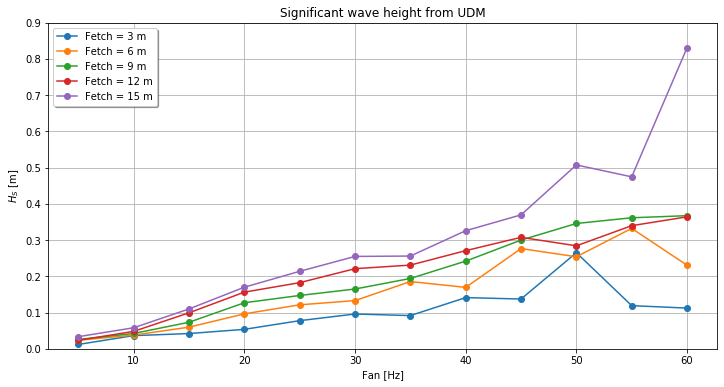

In [10]:
fig = plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(fan[1:], Hs[:,i], marker='o', label='Fetch = ' + str(fetch[i]) + ' m')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.title('Significant wave height from UDM')
plt.xlabel('Fan [Hz]')
plt.ylabel(r'$H_S$ [m]')
plt.ylim(0, 0.9)

Text(0.5, 1.0, 'Significant wave height [m] from UDM')

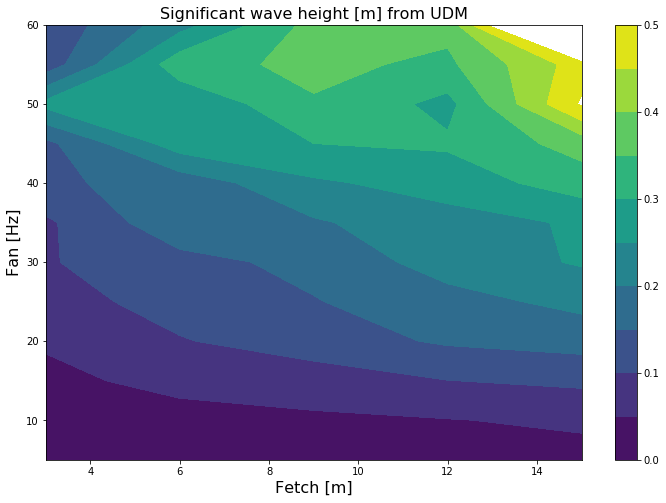

In [11]:
fig = plt.figure(figsize=(12, 8))
plt.contourf(fetch, fan[1:], Hs, np.arange(0, 0.55, 0.05))
plt.colorbar()
plt.xlabel('Fetch [m]', fontsize=16)
plt.ylabel('Fan [Hz]', fontsize=16)
plt.title('Significant wave height [m] from UDM', fontsize=16)

(0, 1.6)

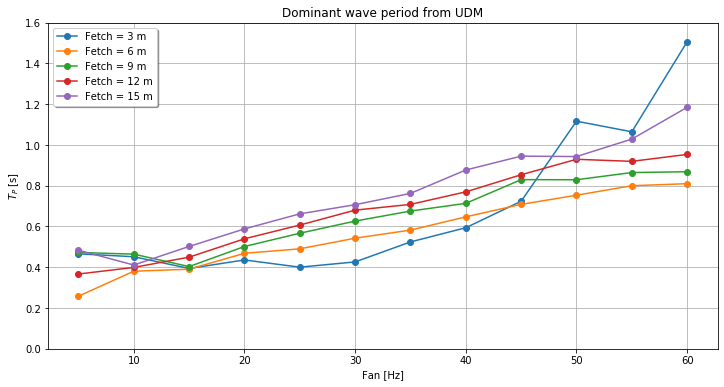

In [12]:
fig = plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(fan[1:], Tp[:,i], marker='o', label='Fetch = ' + str(fetch[i]) + ' m')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.title('Dominant wave period from UDM')
plt.xlabel('Fan [Hz]')
plt.ylabel(r'$T_P$ [s]')
plt.ylim(0, 1.6)

Text(0.5, 1.0, 'Dominant wave period [s] from UDM')

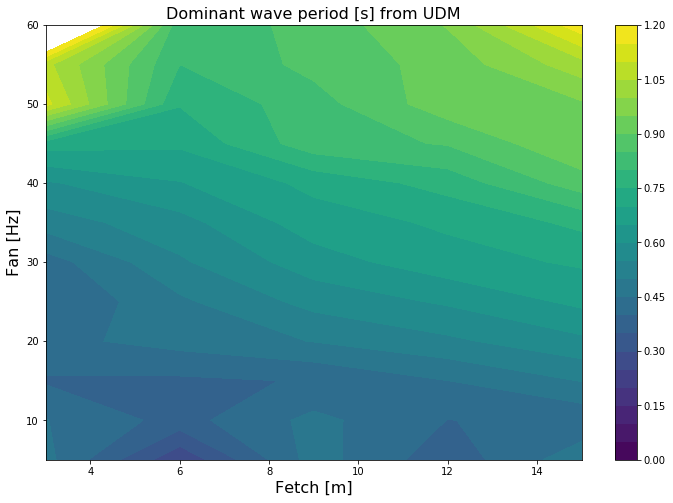

In [13]:
fig = plt.figure(figsize=(12, 8))
plt.contourf(fetch, fan[1:], Tp, np.arange(0, 1.25, 0.05))
plt.colorbar()
plt.xlabel('Fetch [m]', fontsize=16)
plt.ylabel('Fan [Hz]', fontsize=16)
plt.title('Dominant wave period [s] from UDM', fontsize=16)